In [1]:
!echo "Last updated: `date`"

Last updated: Thu Aug 20 13:59:22 PDT 2020


In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
# from pyro.optim import Adam
# from pyro.infer import SVI, Trace_ELBO
# from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
# from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC
import torch
import torch.distributions.constraints as constraints
from torch.nn.functional import pad
from tqdm import trange

# For ADVI
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, JitTraceEnum_ELBO, JitTrace_ELBO
from pyro.contrib.autoguide import *
from pyro.optim import Adam

In [3]:
# Stick break function
# See: https://pyro.ai/examples/dirichlet_process_mixture.html
def stickbreak(v):
    cumprod_one_minus_v = torch.cumprod(1 - v, dim=-1)
    v_one = pad(v, (0, 1), value=1)
    one_c = pad(cumprod_one_minus_v, (1, 0), value=1)
    return v_one * one_c

In [4]:
# See: https://pyro.ai/examples/gmm.html#
# See: https://pyro.ai/examples/dirichlet_process_mixture.html
# See: https://forum.pyro.ai/t/fitting-models-with-nuts-is-slow/1900

# DP SB GMM model.
# NOTE: In pyro, priors are assigned to parameters in the following manner:
#
#   random_variable = pyro.sample('name_of_random_variable', some_distribution)
#
# Note that random variables appear on the left hand side of the `pyro.sample` statement.
# Data will appear *inside* the `pyro.sample` statement, via the obs argument.
# 
# In this example, labels are explicitly mentioned. But they are, in fact, marginalized
# out automatically by pyro. Hence, they do not appear in the posterior samples.
#
# Both marginalized and auxiliary variabled versions are equally slow.
def dp_sb_gmm(y, num_components):
    # Cosntants
    N = y.shape[0]
    K = num_components
    
    # Priors
    # NOTE: In pyro, the Gamma distribution is parameterized with shape and rate.
    # Hence, Gamma(shape, rate) => mean = shape/rate
    alpha = pyro.sample('alpha', dist.Gamma(1, 10))
    
    with pyro.plate('mixture_weights', K - 1):
        v = pyro.sample('v', dist.Beta(1, alpha, K - 1))
    
    eta = stickbreak(v)
    
    with pyro.plate('components', K):
        mu = pyro.sample('mu', dist.Normal(0., 3.))
        sigma = pyro.sample('sigma', dist.Gamma(1, 10))

    with pyro.plate('data', N):
        # Mixture version.
        pyro.sample('obs', dist.MixtureSameFamily(
            dist.Categorical(eta), dist.Normal(mu, sigma)), obs=y)
        # Local variables version.
        # label = pyro.sample('label', dist.Categorical(eta), infer={"enumerate": "parallel"})
        # pyro.sample('obs', dist.Normal(mu[label], sigma[label]), obs=y)

In [5]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
    simdata = json.load(f)

In [6]:
# Convert data to torch.tensor.
y = torch.tensor(simdata['y'])

100%|██████████| 2000/2000 [00:08<00:00, 239.15it/s]

CPU times: user 16.7 s, sys: 108 ms, total: 16.8 s
Wall time: 8.41 s


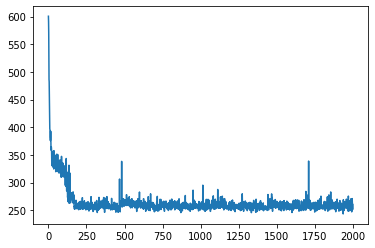

In [7]:
%%time 

# See: https://pyro.ai/examples/dirichlet_process_mixture.html

pyro.clear_param_store()
pyro.set_rng_seed(2)

# Automatically define mean-field variational distribution.
guide = AutoDiagonalNormal(dp_sb_gmm, init_to_uniform, init_scale=0.1)

elbo = Trace_ELBO()
svi = SVI(dp_sb_gmm, guide, Adam({'lr': 1e-1}), elbo)

# do gradient steps
loss = []
for step in trange(2000):
    _loss = svi.step(y, 10)
    loss.append(_loss)
    
# Plot ELBO    
plt.plot(loss);

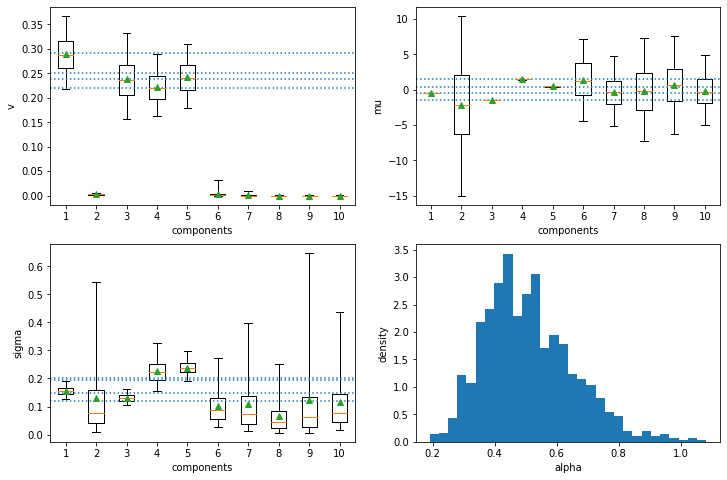

In [8]:
samples = guide.get_posterior().sample((1000, ))
alpha = samples[:, 0].exp()
v = samples[:, 1:10].sigmoid()
mu = samples[:, 10:20]
sigma = samples[:, 20:30].exp()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.boxplot(stickbreak(v).numpy(), whis=[2.5, 97.5], showmeans=True, showfliers=False)
for line in simdata['w']: plt.axhline(line, ls=":")
plt.xlabel('components')
plt.ylabel('v')

plt.subplot(2, 2, 2)
plt.boxplot(mu.numpy(), whis=[2.5, 97.5], showmeans=True, showfliers=False)
for line in simdata['mu']: plt.axhline(line, ls=":")
plt.xlabel('components')
plt.ylabel('mu')

plt.subplot(2, 2, 3)
plt.boxplot(sigma.numpy(), whis=[2.5, 97.5], showmeans=True, showfliers=False)
for line in simdata['sig']: plt.axhline(line, ls=":")
plt.xlabel('components')
plt.ylabel('sigma')

plt.subplot(2, 2, 4)
plt.hist(alpha.numpy(), bins=30, density=True)
plt.xlabel('alpha')
plt.ylabel('density');

In [9]:
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up HMC sampler.
kernel = HMC(dp_sb_gmm, step_size=0.01, trajectory_length=1, 
             adapt_step_size=False, adapt_mass_matrix=False, jit_compile=True)
hmc = MCMC(kernel, num_samples=500, warmup_steps=500)
hmc.run(y, 10)

# 06:13 for marginalized version.

# Get posterior samples
hmc_posterior_samples = hmc.get_samples()
hmc_posterior_samples['eta'] = stickbreak(hmc_posterior_samples['v'])

Warmup:   0%|          | 0/1000 [00:00, ?it/s]/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Sample: 100%|██████████| 1000/1000 [02:58,  5.62it/s, step size=1.00e-02, acc. prob=0.853]


In [10]:
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up NUTS sampler.
kernel = NUTS(dp_sb_gmm, target_accept_prob=0.8, jit_compile=True)
nuts = MCMC(kernel, num_samples=500, warmup_steps=500)
nuts.run(y, 10)

# 44:07 for marginalized version.

# Get posterior samples
nuts_posterior_samples = nuts.get_samples()
nuts_posterior_samples['eta'] = stickbreak(nuts_posterior_samples['v'])

Warmup:   0%|          | 0/1000 [00:00, ?it/s]/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Sample: 100%|██████████| 1000/1000 [18:26,  1.11s/it, step size=7.57e-03, acc. prob=0.804]


In [11]:
def plot_param_post(params, param_name, param_full_name, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)
    param = params[param_name].numpy()

    plt.subplot(1, 2, 1)
    plt.boxplot(param, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [12]:
def plot_all_params(params):
    plot_param_post(params, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(params, 'mu', 'mixture locations', truth=simdata['mu'])
    plot_param_post(params, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(params['alpha'], bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha");

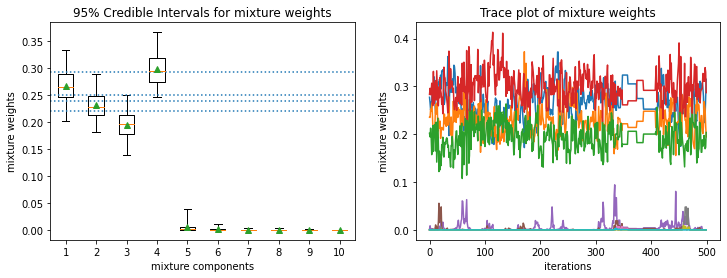

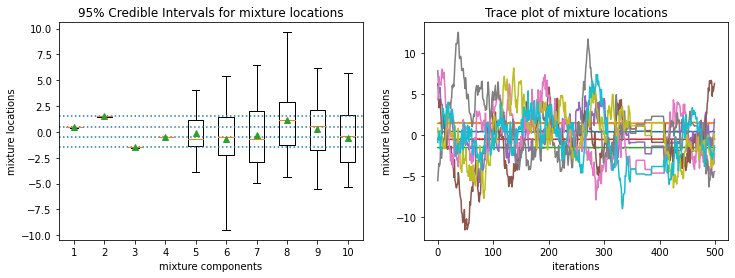

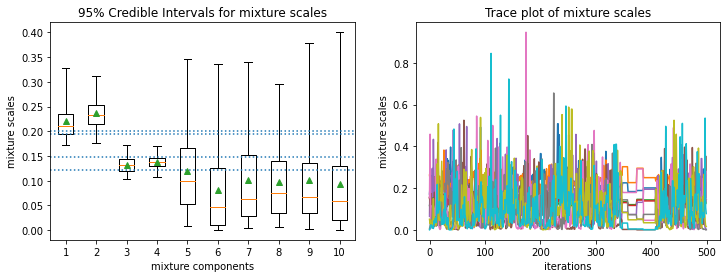

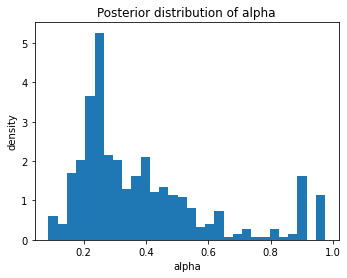

In [13]:
plot_all_params(hmc_posterior_samples)

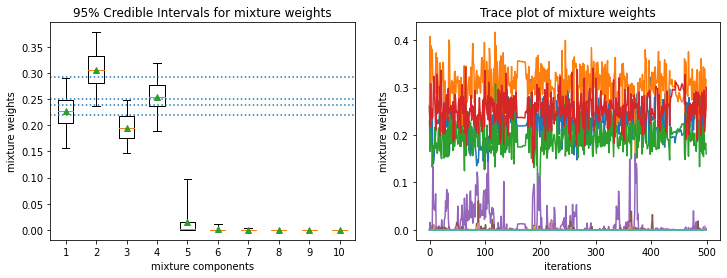

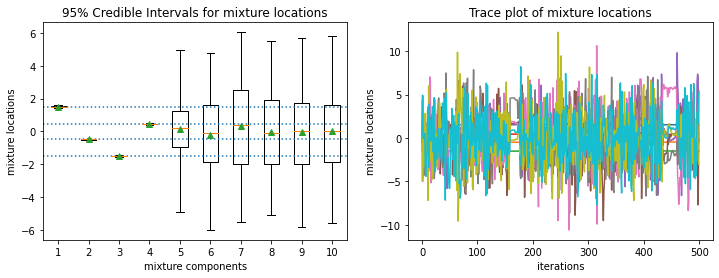

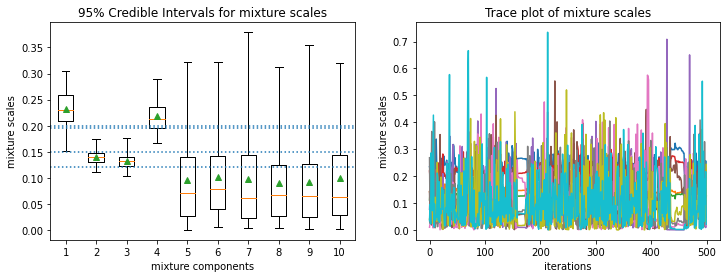

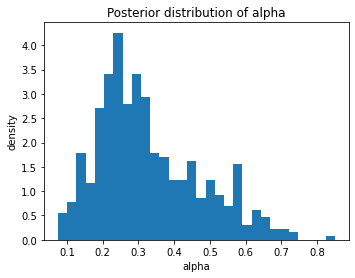

In [14]:
plot_all_params(nuts_posterior_samples)